# Linear Regression Assignment 

### By Venkata Sreeleela Sappa

#### Objective: To build a multiple linear regression model for the prediction of demand for shared bikes. The data for the analysis is provided based on various meteorological surveys and people's styles.This data is a  large dataset on daily bike demands across the American market based on some factors. 

In [1]:
## import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import r2_score


In [2]:
## Loading the data in new DataFrame
df = pd.read_csv('day.csv')

# 1. Data Understanding :

In [3]:
#display First 5 Rows of df
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
df.shape

(730, 16)

In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


### 1.1 Business Understanding : 
A US bike-sharing provider BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. They have planned this to prepare themselves to cater to the people's needs once the situation gets better all around and stand out from other service providers and make huge profits.
### 1.2. Business Goal:
We have to model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market. 
### 1.3 Data Set Understanding :
Initial understanding of the data by looking at the dataset :
1. All the columns are non-null. We need not address the null values as part of EDA. 
2. The column instant is a record index,with all unique values. We can drop this column for analysis.
3. The data set has information of bike rentals in two consecutive years 2018 and 2019.
4. dteday column has date formats skewed, we need to tackle it before analysis.
5. The count of bike sales by casual customers, registered customers and the overall count breakdown is provided.
6. season is a categorical variable with definition as (1:spring, 2:summer, 3:fall, 4:winter)
7.  weathersit column is explained as : (1: Clear, Few clouds, Partly cloudy, Partly cloudy,2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist,3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds,4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog)


# 2. Data Cleaning : 

#### 2.1. Drop column instant as this has all unique values and is not useful for analysis.

In [6]:
df.drop('instant',axis=1,inplace=True)

In [7]:
df.shape

(730, 15)

#### 2.1. Check and drop duplicates if any 

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.shape
#there are no duplicates in the dataset

(730, 15)

#### 2.2. Remaning Columns for better understandability

In [10]:
df.rename(columns={'yr':'year','mnth':'month','hum':'humidity'}, inplace=True)

#### 2.3. Formatting the date column 
We see that the date column dteday has different format form dates 1 to 12 and 13 to 31, Ideally we should be adjusting this column for analysis.But, We don't need the Feature 'dteday' because it is already expalained by the other features like: yr, mnth, weekday, workingday and holiday. Hence dropping it

In [11]:
df.drop('dteday',axis=1,inplace=True)

In [12]:
df.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


#### 2.4. Modifying the values of categorical variables to be more readable 

In [13]:
df.season = df.season.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
df.month = df.month.map({1:'jan',2:'feb',3:'mar',4:'apr',5:'may',6:'june',7:'july',8:'aug',9:'sep',10:'oct',11:'nov',12:'dec'})
df.weekday = df.weekday.map({0:'sun',1:'mon',2:'tue',3:'wed',4:'thu',5:'fri',6:'sat'})
df.weathersit = df.weathersit.map({1:'Clear',2:'Mist',3:'LightSnow',4:'HeavyRain'})
df.year = df.year.map({0:2018,1:2019})

In [14]:
df.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,casual,registered,cnt
0,spring,2018,jan,0,sat,0,Mist,14.110847,18.18125,80.5833,10.749882,331,654,985
1,spring,2018,jan,0,sun,0,Mist,14.902598,17.68695,69.6087,16.652113,131,670,801
2,spring,2018,jan,0,mon,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,spring,2018,jan,0,tue,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,spring,2018,jan,0,wed,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


# 3. Data Visualization and Analysis:

#### 3.1. Define functions for visualization 

In [15]:
# box plots of all columns against hue as the column for prediction 'cnt'
def box_plot(cols_list) :    
    plt.figure(figsize=(20, 12))
    num=0;
    for i in cols_list :
        column=i
        num=num+1
        plt.subplot(2,4,num)
        sns.boxplot(x = column, y = 'cnt', data = df)
    plt.show()

# Defining function to create barplot for categorical columns
def plot_cat_col(column):
    plt.figure(figsize = (12,6))
    plt.subplot(1,2,1)
    sns.barplot(x=column,y='cnt',data=df)
    plt.subplot(1,2,2)
    sns.barplot(x=column,y='cnt',data=df, hue='year',palette = 'Set3' )
    plt.legend(labels=['2018', '2019'])
    plt.show()


def plot_cat_col_list(cols_list) :    
     for i in cols_list :
        plot_cat_col(i)

#### 3.2. Visualization of categorical variables : 

The following categorical Variables are identified from the data : 
1. season :spring,summer,fall,winter
2. year : 2018,2019
3. month: jan,feb,mar,apr,may,june,july,aug,sep,oct,nov,dec
4. holiday : 0,1
5. weekday : sun,mon,tue,wed,thu,fri,sat
6. workingday : 0,1
7. weathersit : Clear,Mist,LightSnow,HeavyRain

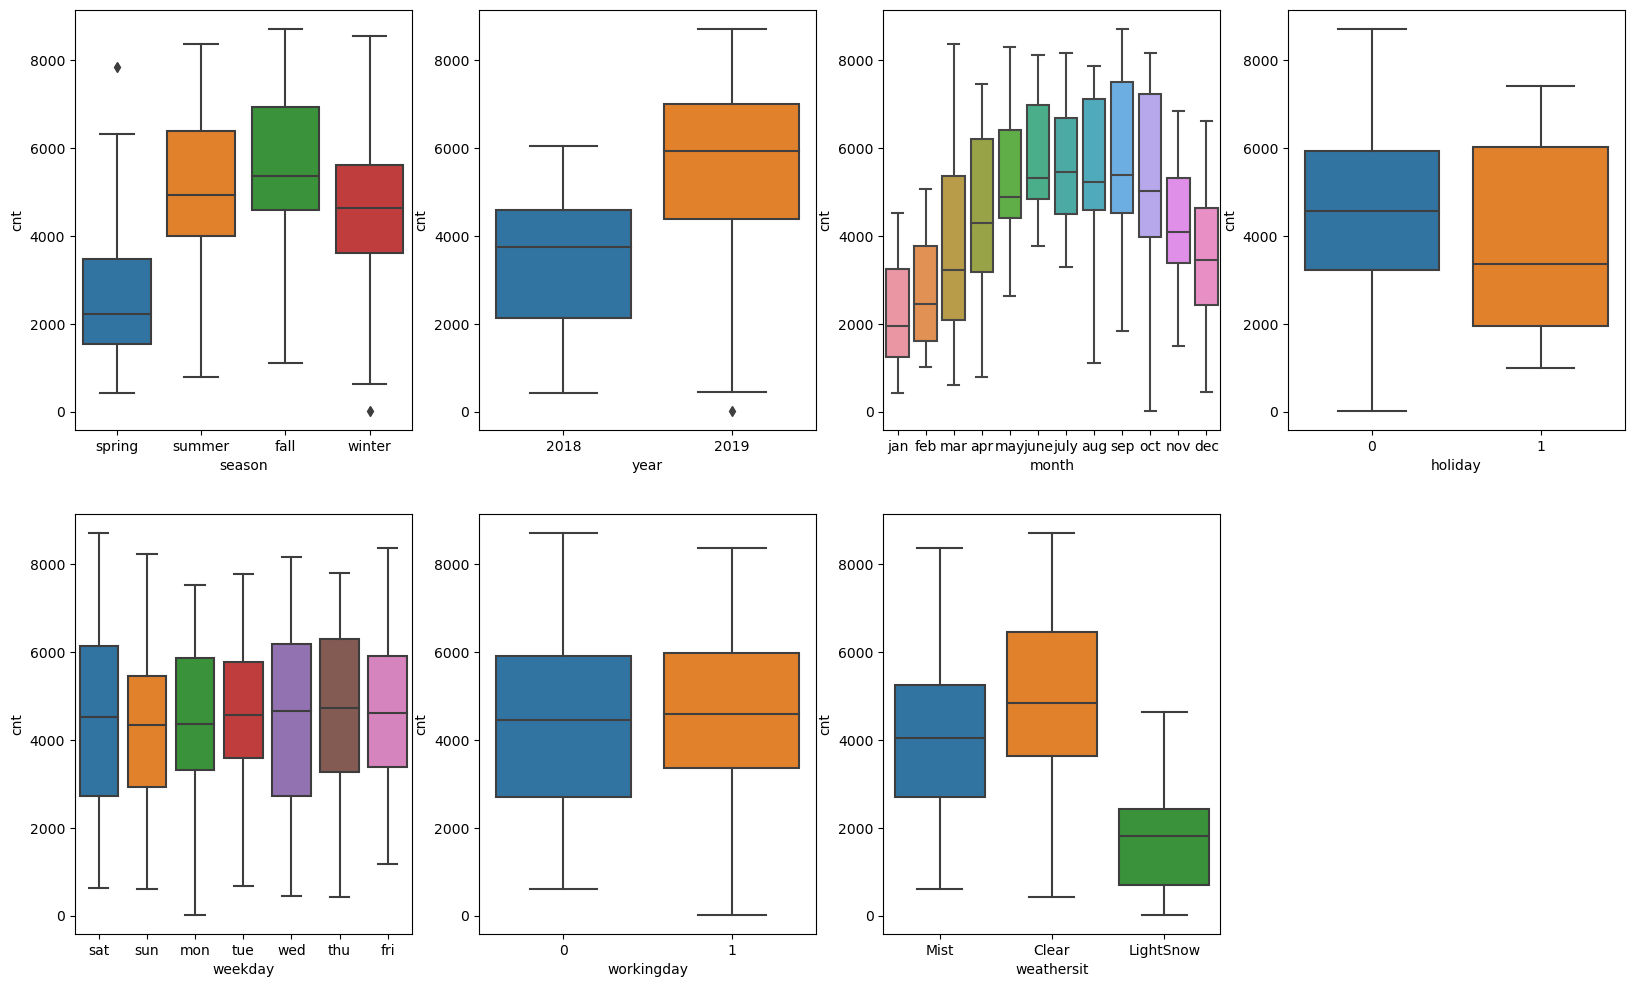

In [16]:
categorical_cols=['season','year','month','holiday','weekday','workingday','weathersit']
box_plot(categorical_cols)
#count_plot(['weathersit'],1,1)

##### 3.2.1. Observations: 
1. Demand is considerably low in Spring, and picks up during the other seasons 
2. Demand is more in 2019 compared to 2018 
3. Weather Situations influence the demand considerably. 
4. Strangely workingday or a holiday is not influencing the demand considerably. 


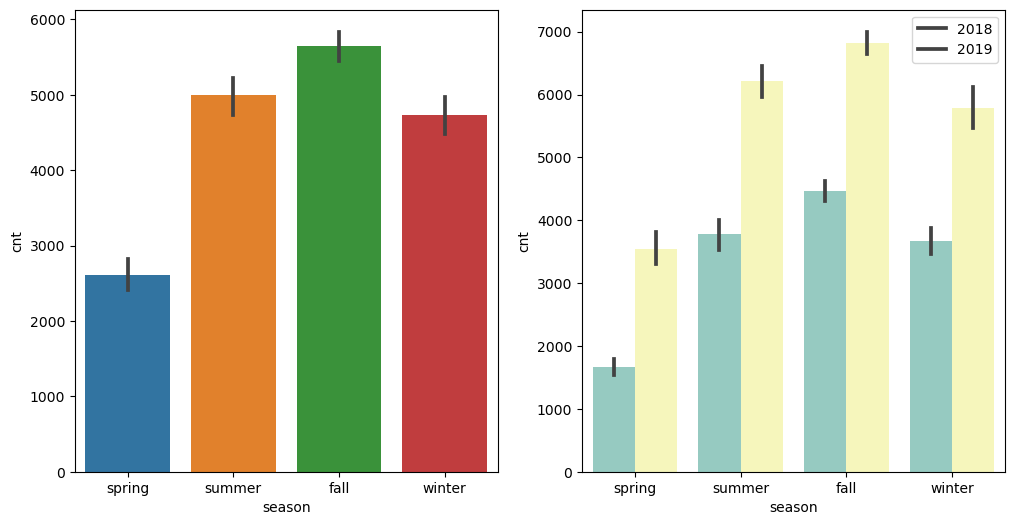

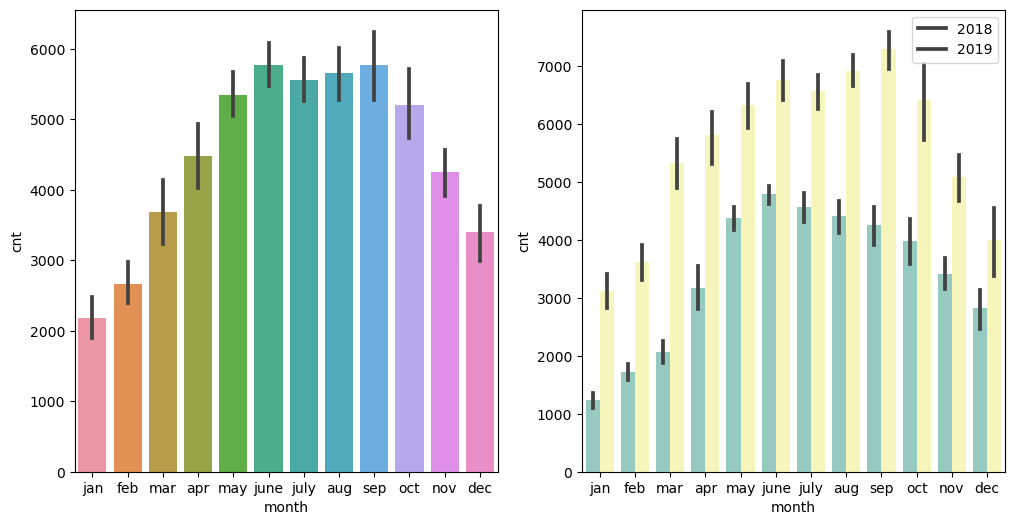

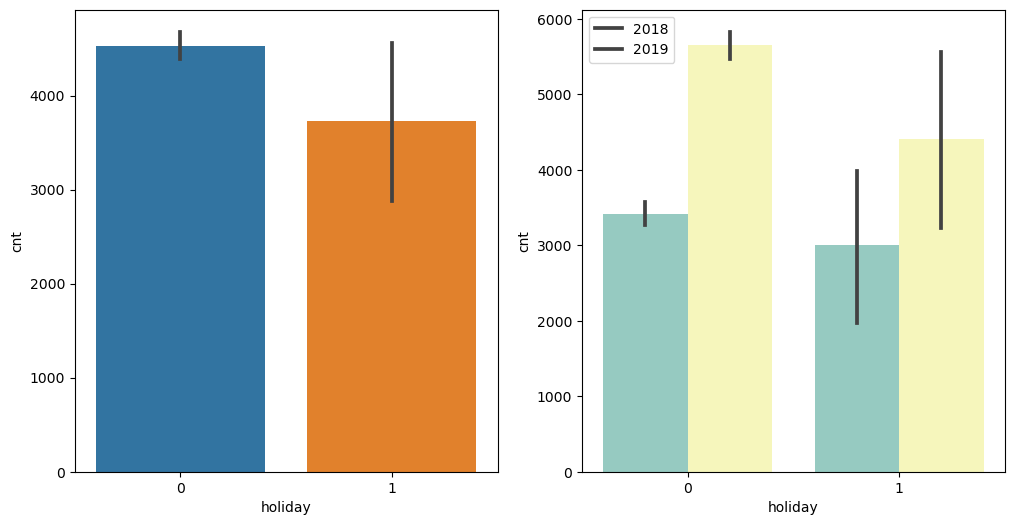

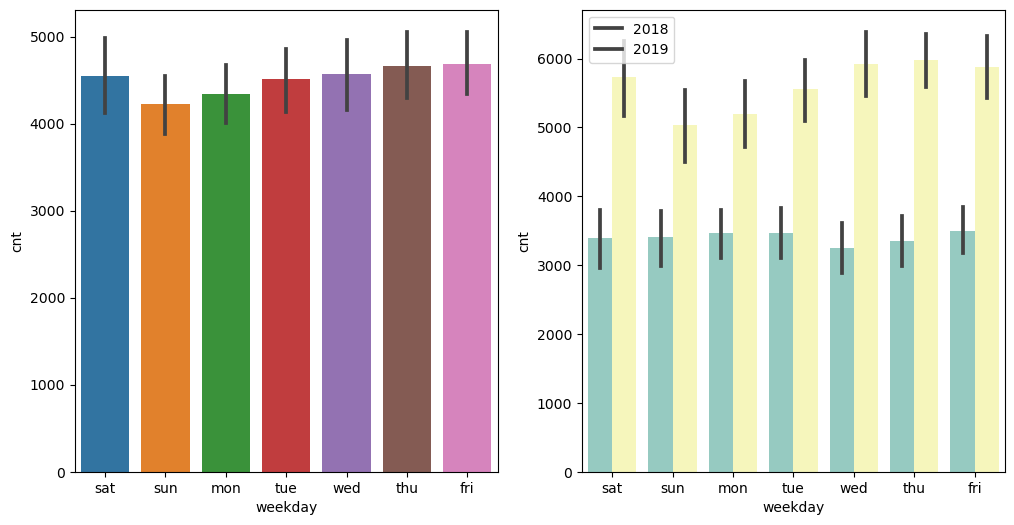

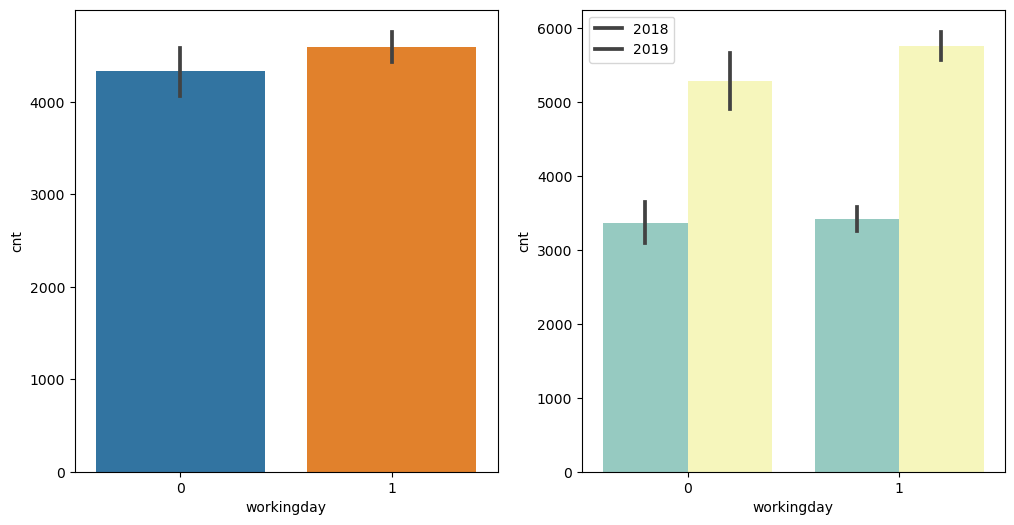

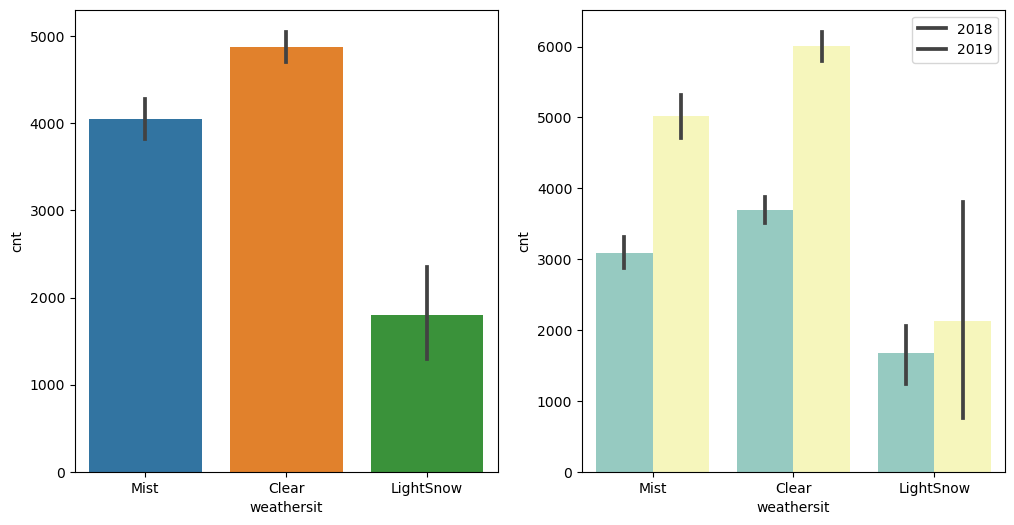

In [17]:
#removing year as we are studying dependnecy of all with year w.r.t counts
categorical_cols=['season','month','holiday','weekday','workingday','weathersit']
plot_cat_col_list(categorical_cols)

##### 3.2.2. Observations
1. Fall season has highest demand.
2. Across all seasons booking increased in 2019.
3. Demand increase till mid year and again started to fall .
4. Number of booking per month also incresed from year 2018 to 2019 .
5. Demand is high when weather conditions are good. 
6. Irrespective of weather conditions, bookings increased in 2019. 
7. The influence of holiday/ working day on the cnt param directly is minimal.

#### 3.3. Visualization of continuous variables
The following continous Variables are identified from the data :
1. temp : temperature in Celsius
2. atemp: feeling temperature in Celsius
3. hum: humidity
4. windspeed: wind speed
5. casual: count of casual users
6. registered: count of registered users
7. cnt: count of total rental bikes including both casual and registered



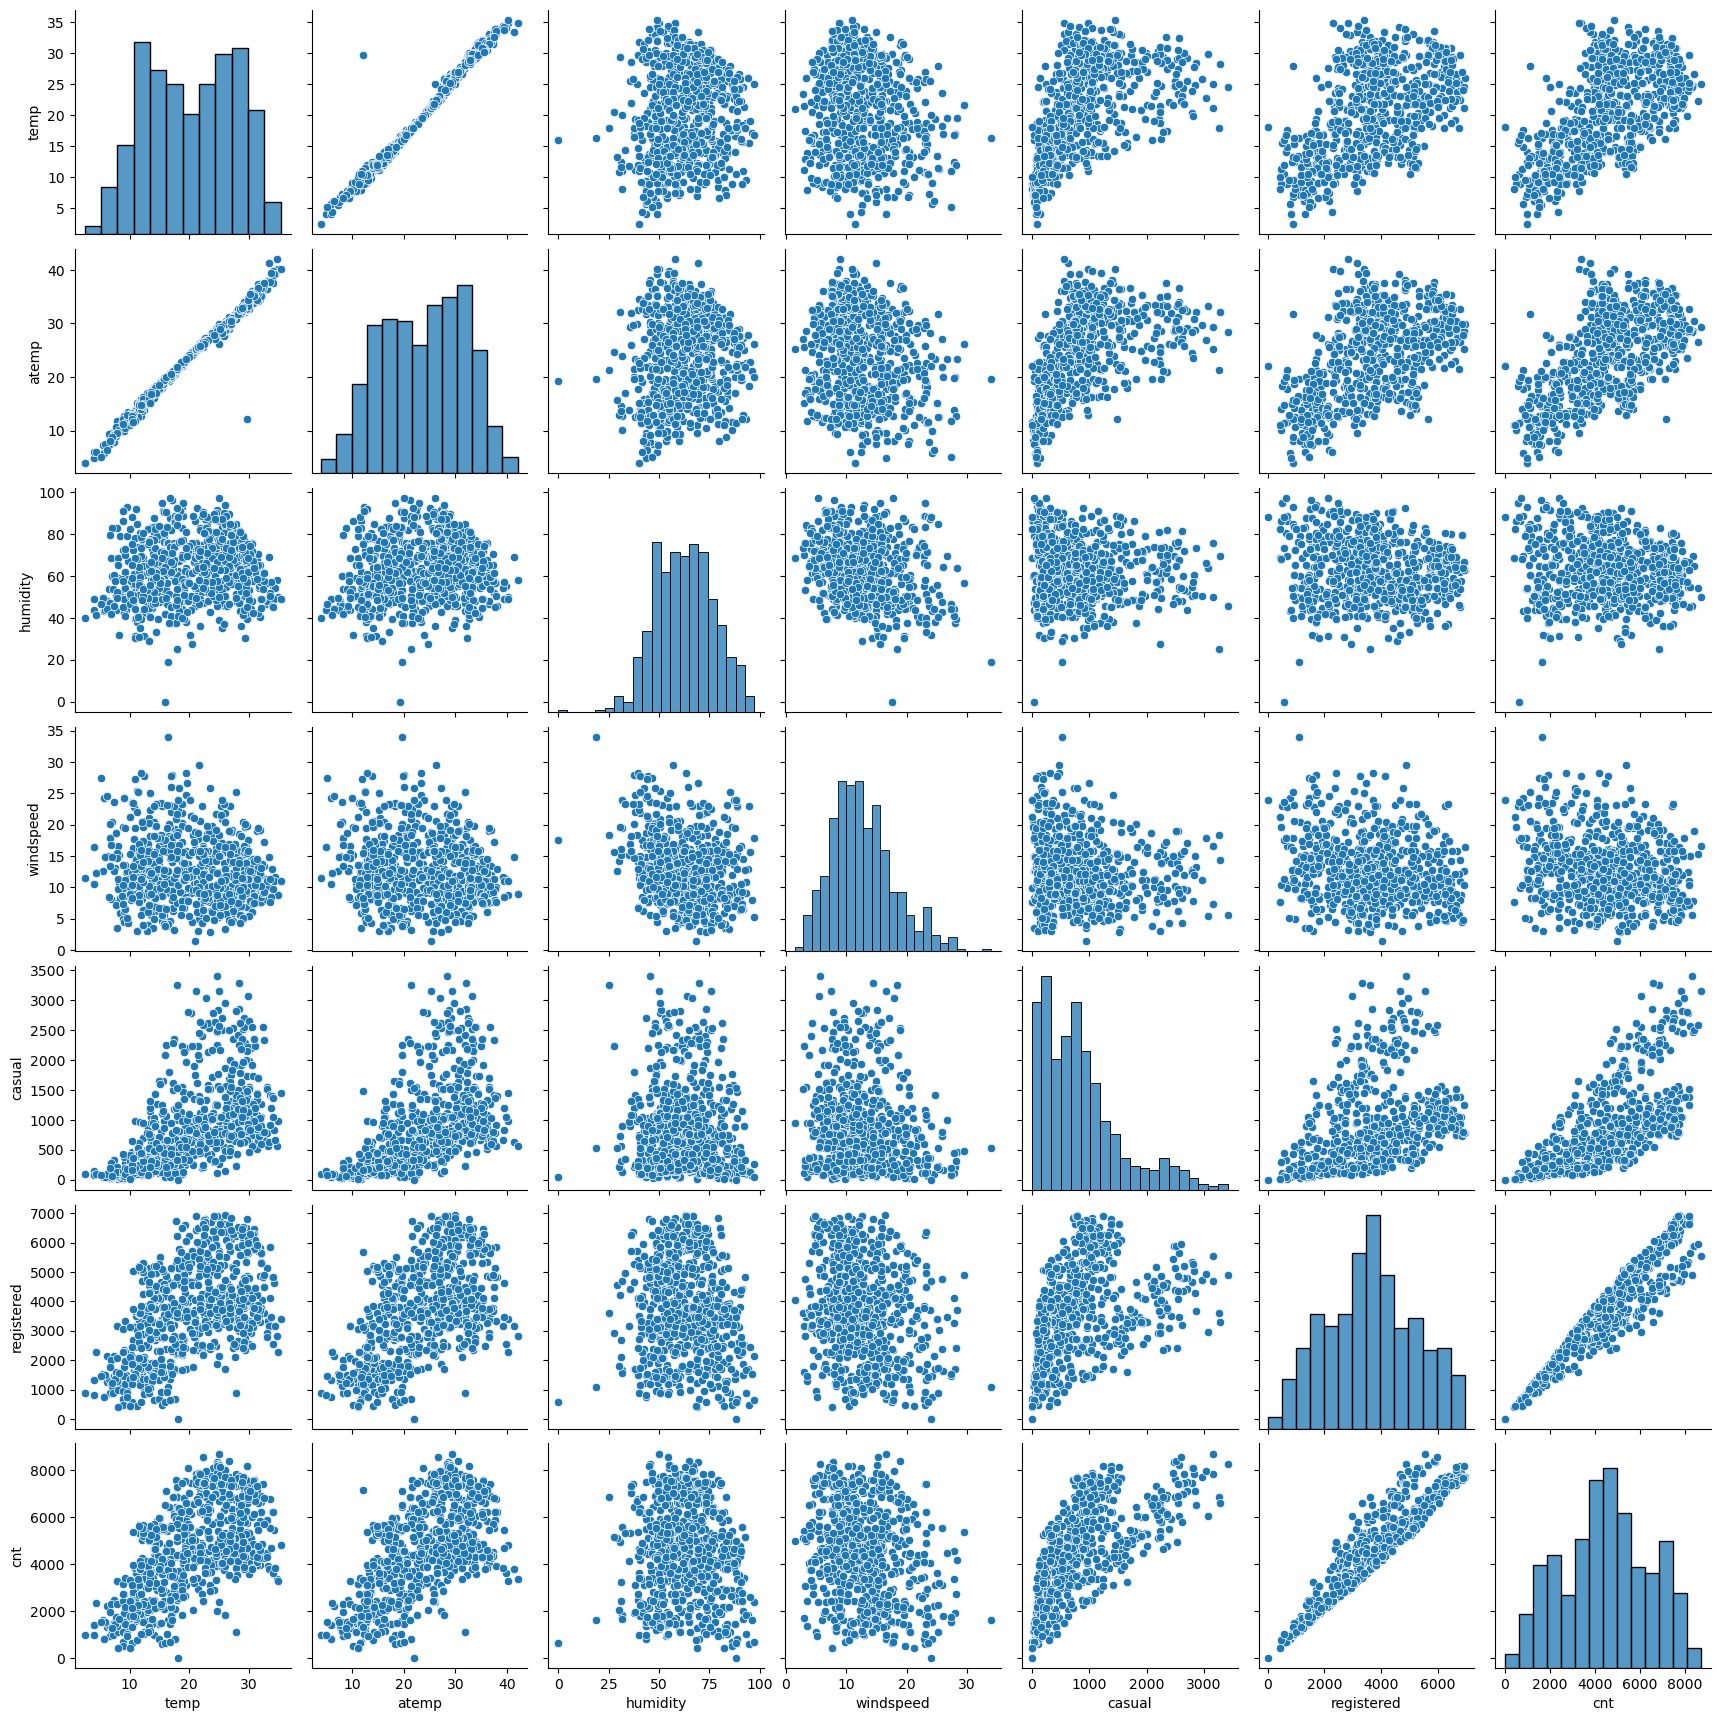

In [18]:
# visualizing, Analysing the numerical columns
sns.pairplot(data=df,vars=['temp','atemp','humidity','windspeed','casual','registered','cnt'])
plt.show()

##### 3.3.1. Observations:
1. Above Plot shows linear relationship between temp and atemp. Both parameters cannot be used in the model because to Multi-Colinearity. Need to decide which parameters to keep based on VIF and P-Value with respect to other variables.
2. Registered and cnt also exhibit multi-colinearity. But dont see the same between casual and registered.

#### 3.4. Correlation among all the variables in the dataset

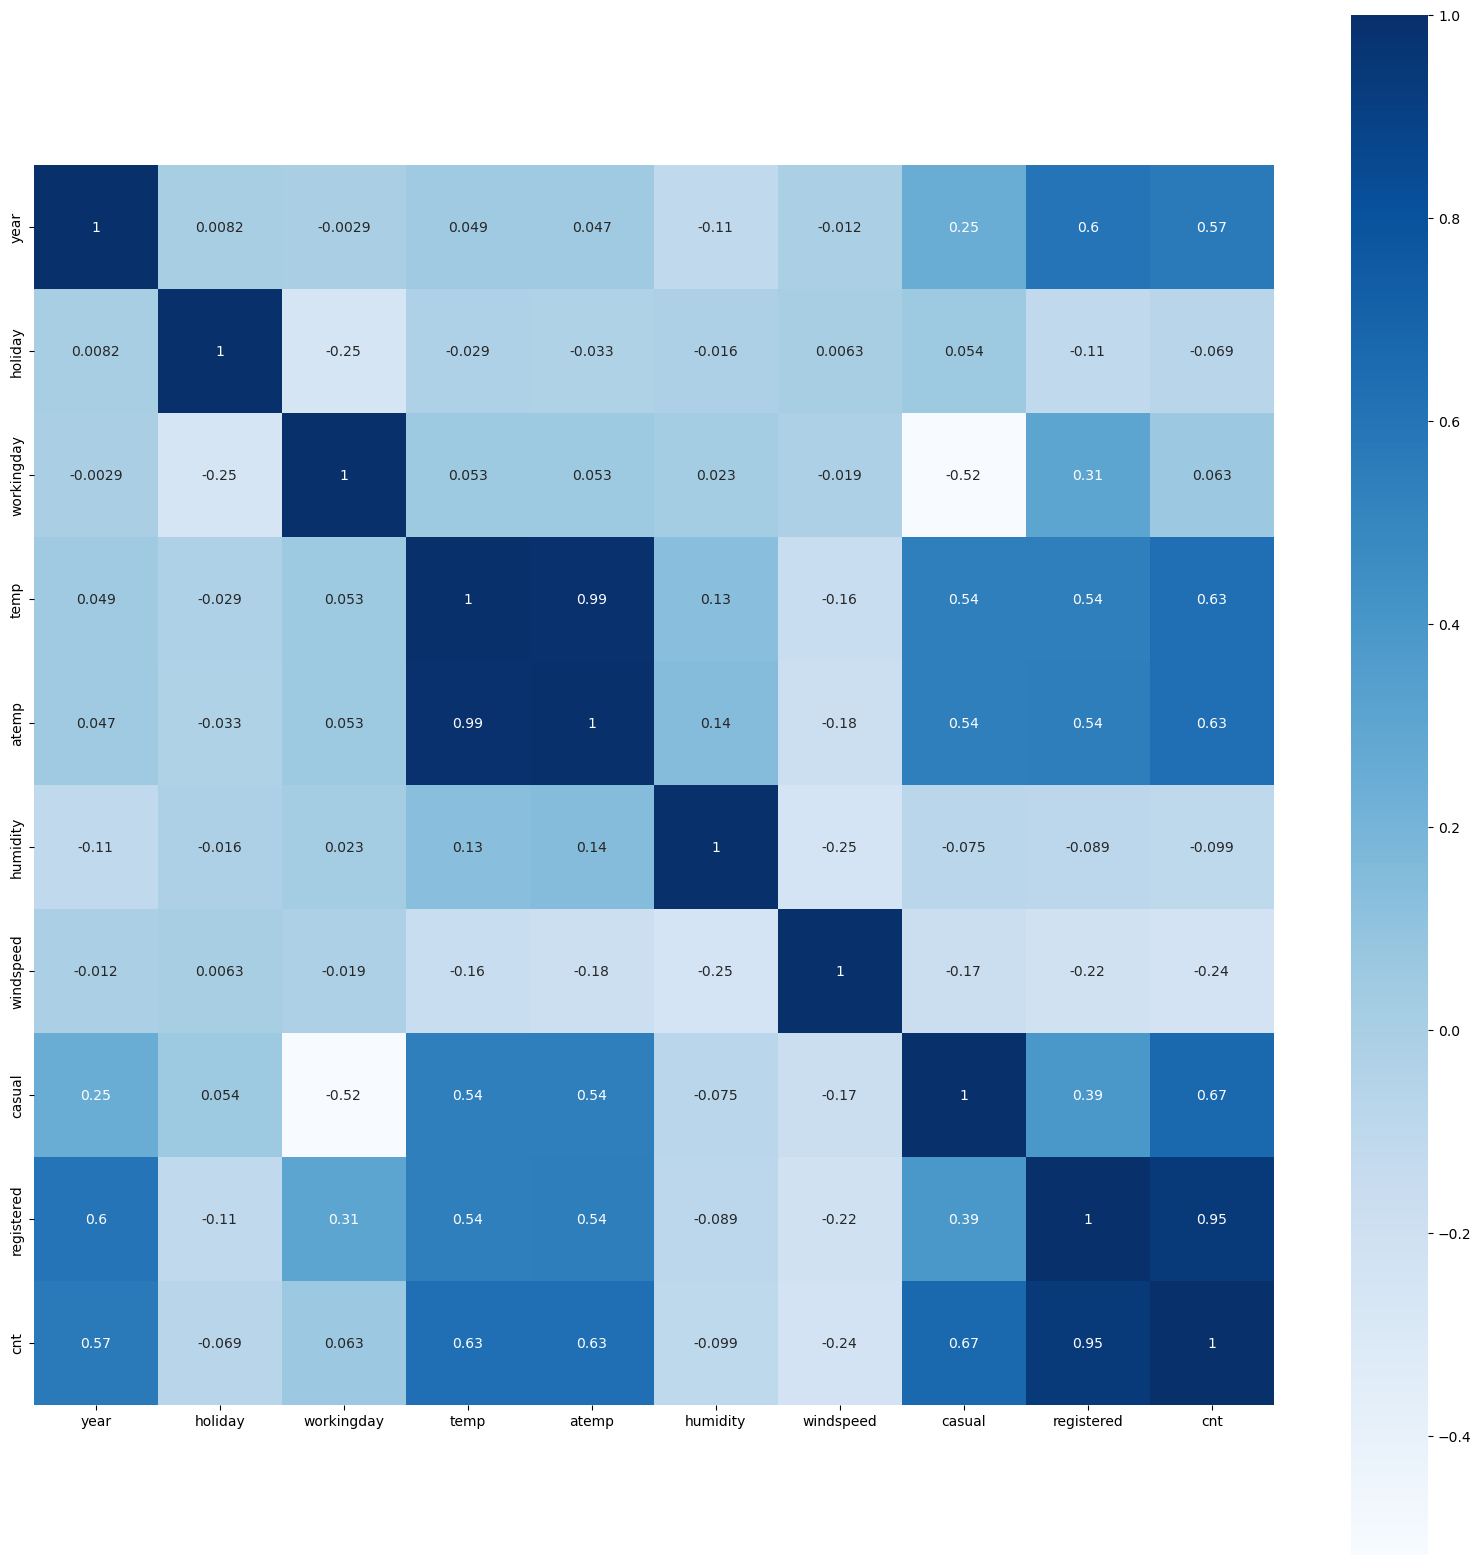

In [19]:
# Creating a correlation heatmap
plt.figure(figsize=(20,20))
correlation = df.corr()
sns.heatmap(correlation, annot=True,square=True, cmap='Blues')
plt.show()

##### 3.4.1. Observations: 
1. atemp and temp are highly correlated. We need to remove 1 on them based on p-value .
2. we also notice high correlation between cnt and temp/atemp, makign it an interesting variable for prediction. 
3. year and count also exhibit high correlation. 



# 4. Data Preparation:

In this step, we will be majorly dealing with creating dummies for the relevant Categorical variables, so that they are ready for regression models to consume.


#### 4.1. Creating dummies

In [20]:
# Creation of Dummy variables for month, weekday, weathersit and season variables.
months_df=pd.get_dummies(df.month,drop_first=True)
weekdays_df=pd.get_dummies(df.weekday,drop_first=True)
weathersit_df=pd.get_dummies(df.weathersit,drop_first=True)
seasons_df=pd.get_dummies(df.season,drop_first=True)
df.year = df.year.map({2018:0,2019:1})

# Merging  the dataframe with the newly created dummy variables. 
df = pd.concat([df,months_df,weekdays_df,weathersit_df,seasons_df],axis=1)


# dropping unwanted columns as we have already created dummy variables.
df.drop(['season','month','weekday','weathersit'], axis = 1, inplace = True)


df.head()

,year,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,cnt,...,sat,sun,thu,tue,wed,LightSnow,Mist,spring,summer,winter
0,0,0,0,14.110847,18.18125,80.5833,10.749882,331,654,985,...,1,0,0,0,0,0,1,1,0,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,131,670,801,...,0,1,0,0,0,0,1,1,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,...,0,0,0,1,0,0,0,1,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,...,0,0,0,0,1,0,0,1,0,0


#### 4.2 Data Split- Training and Testing Sets

In [21]:
# split the dataframe into Train and Test sets 70/30
df_train, df_test = train_test_split(df, train_size = 0.7, random_state = 100) 

In [22]:
df_train.shape

(510, 32)

In [23]:
df_train.head()

,year,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,cnt,...,sat,sun,thu,tue,wed,LightSnow,Mist,spring,summer,winter
576,1,0,1,29.246653,33.1448,70.4167,11.083475,968,6248,7216,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,16.980847,20.6746,62.1250,10.792293,956,3110,4066,...,1,0,0,0,0,0,1,1,0,0
728,1,0,0,10.489153,11.5850,48.3333,23.500518,364,1432,1796,...,0,1,0,0,0,0,0,1,0,0
482,1,0,0,15.443347,18.8752,48.9583,8.708325,1120,3100,4220,...,1,0,0,0,0,0,1,0,1,0
111,0,0,1,13.803347,16.0977,72.9583,14.707907,177,1506,1683,...,0,0,0,0,0,0,1,0,1,0


#### 4.3. Rescaling the training data

In [24]:
scaler = MinMaxScaler()

# Apply scaler to all the columns except 'yes-no' and 'dummy' variables
continous_vars = ['temp','atemp','humidity','windspeed','casual','registered','cnt']
df_train[continous_vars] = scaler.fit_transform(df_train[continous_vars])

# head after scaling
df_train.head()


,year,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,cnt,...,sat,sun,thu,tue,wed,LightSnow,Mist,spring,summer,winter
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.294422,0.899220,0.827658,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.290765,0.446145,0.465255,...,1,0,0,0,0,0,1,1,0,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.110332,0.203869,0.204096,...,0,1,0,0,0,0,0,1,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.340750,0.444701,0.482973,...,1,0,0,0,0,0,1,0,1,0
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0.053337,0.214554,0.191095,...,0,0,0,0,0,0,1,0,1,0


In [25]:
df_train.describe()

,year,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,cnt,...,sat,sun,thu,tue,wed,LightSnow,Mist,spring,summer,winter
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537440,0.513156,0.650480,0.320883,0.254689,0.523781,0.513499,...,0.154902,0.143137,0.133333,0.131373,0.158824,0.029412,0.345098,0.243137,0.247059,0.247059
std,0.500429,0.157763,0.468282,0.225858,0.212410,0.145846,0.169803,0.206015,0.227896,0.224421,...,0.362166,0.350557,0.340268,0.338139,0.365870,0.169124,0.475867,0.429398,0.431725,0.431725
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.094179,0.353487,0.356420,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.212740,0.525123,0.518638,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.327415,0.696073,0.684710,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 4.4. Visualization on the training data set

##### Correlation heat map 

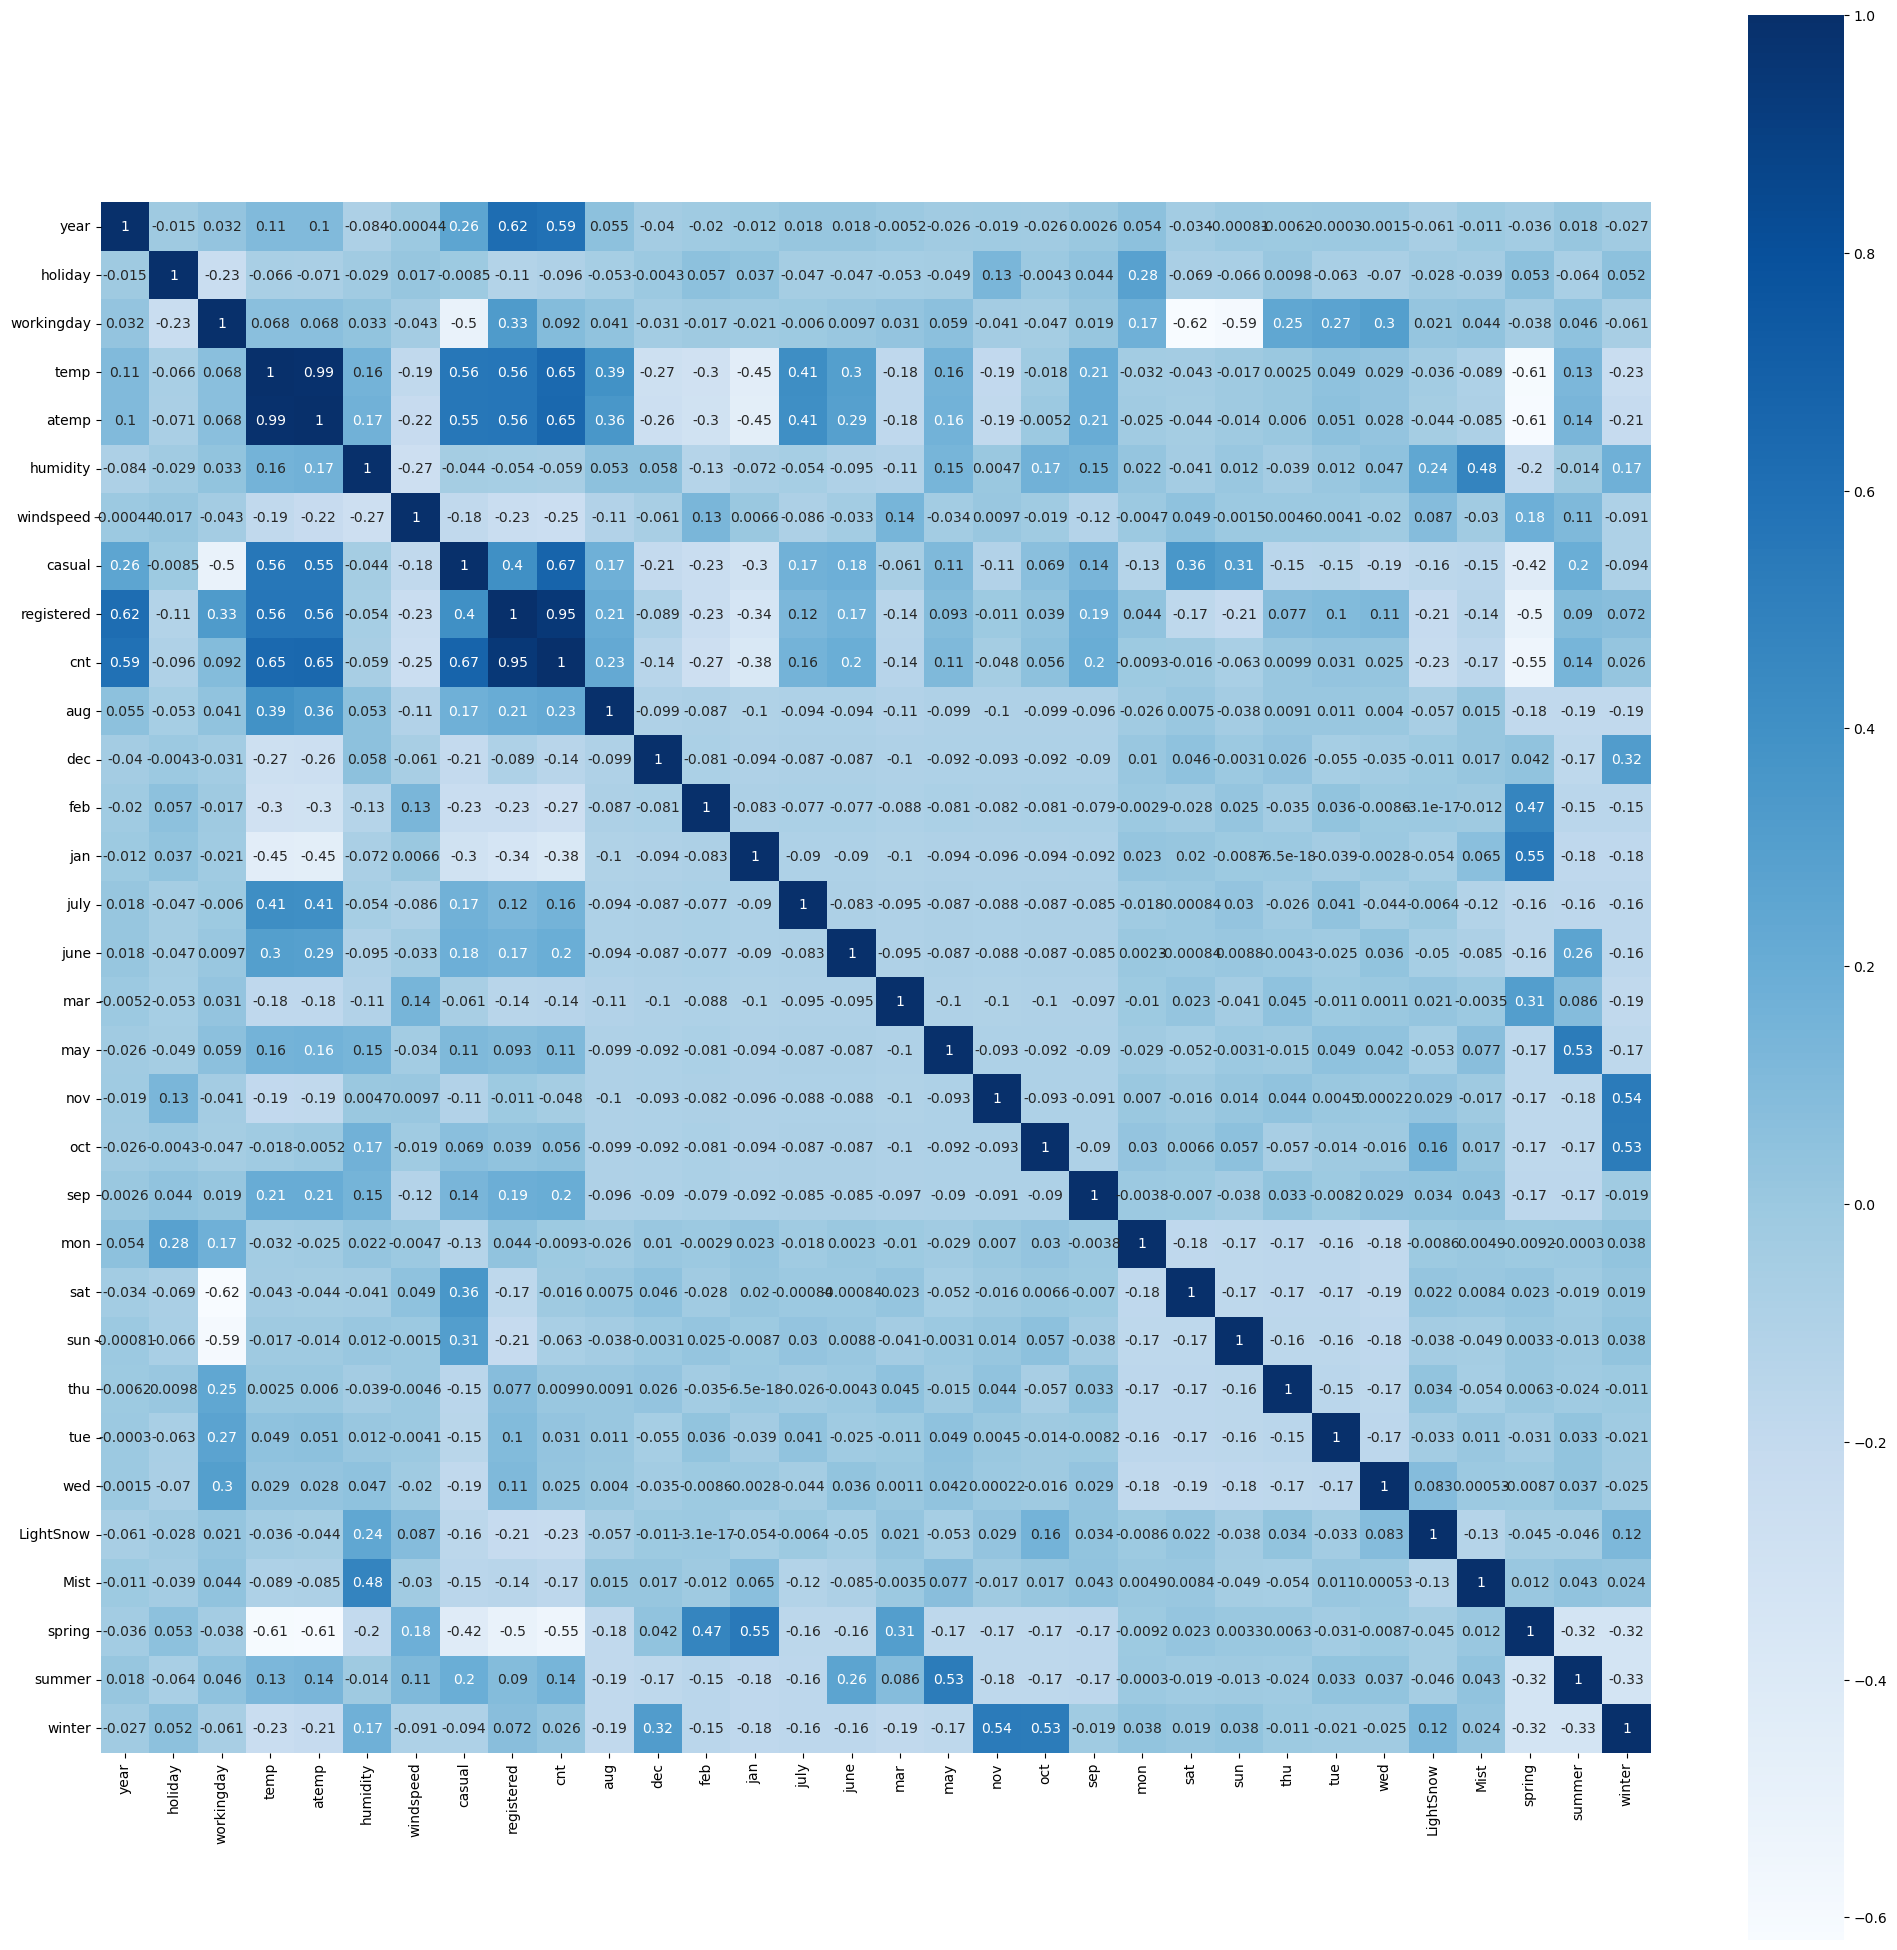

In [26]:
# Creating a correlation heatmap
plt.figure(figsize=(25,25))
correlation = df_train.corr()
sns.heatmap(correlation, annot=True,square=True, cmap='Blues')
plt.show()

##### 4.4.1. Observations:
1. We can still see the correlation we observed in the initial data set. 
2. temp and atemp are correlated heavily 
3. temp, atemp,year and registered have high correlation with cnt.
4. We can also see the explicit correlation of seasons to the corresponding months. 
Spring with jan and feb, Summer with may and winter with oct and nov respectively.

#### Visualizing correlations between temp, registered and cnt 

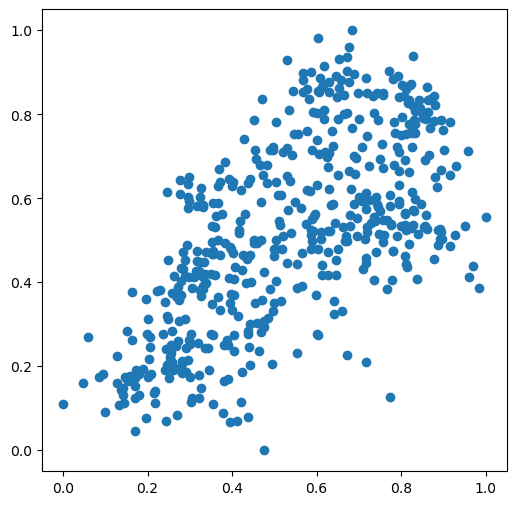

In [27]:
plt.figure(figsize=[6,6])
plt.scatter(df_train.temp, df_train.cnt)
plt.show()

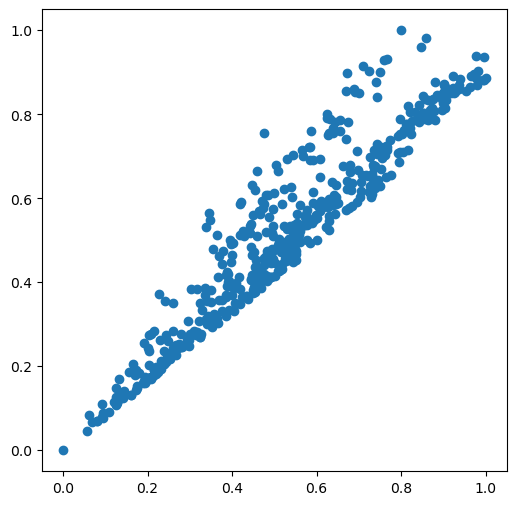

In [28]:
plt.figure(figsize=[6,6])
plt.scatter(df_train.registered, df_train.cnt)
plt.show()

#### 4.4.2. Observations: 
We can see the same correlation explained by the whole dataset in the train set as well. And the linear relation is also explicit. We can proceed with linear regression.Since we are interested in cnt as the target variable and registered is showing very high correlation with cnt, we can drop this variable for analysis. 

In [29]:
# Removing this because, Registered count is in proper linear relationship with the model.
# When using it I am getting a R-squared value of 1
# this metric is overshadowing the other model params as its very highly linearly related with cnt.
# Also tried building models with Casual, Percentage of casual(Casual/cnt*100)  and percentage of registered(registered/cnt*100)
# none of the params show meaningful coefficients and p-values in the final model
#  Hence dropping these columns
df_train=df_train.drop(['registered'], axis = 1)
df_train=df_train.drop(['casual'], axis = 1)


# 5. Building the model

#### 5.1. derive X_train and y_train
Since the target variable is 'cnt',
1. y_train will be populated with cnt
2. X_train will be populated with rest of the predictor variables other than cnt.

In [30]:
y_train = df_train.pop('cnt')
X_train = df_train
X_train.head()

,year,holiday,workingday,temp,atemp,humidity,windspeed,aug,dec,feb,...,sat,sun,thu,tue,wed,LightSnow,Mist,spring,summer,winter
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0,0,0,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0,0,0,...,1,0,0,0,0,0,1,1,0,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0,1,0,...,0,1,0,0,0,0,0,1,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0,0,0,...,1,0,0,0,0,0,1,0,1,0
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [31]:
X_train.shape

(510, 29)

#### 5.2. Feature Selection using RFE(Recursive Feature Elimination)

Since we have 31 features, we will first eliminate using RFE to the most relevant 20 features

In [32]:
lm = LinearRegression()
lm.fit(X_train, y_train)
#running RFE with output param as 20 features to be selected
rfe = RFE(lm,n_features_to_select=20)
rfe = rfe.fit(X_train, y_train)

In [33]:
# selecting the selected variable via RFE in col list
col = X_train.columns[rfe.support_]
print(col)

Index(['year', 'holiday', 'workingday', 'temp', 'atemp', 'humidity',
       'windspeed', 'dec', 'feb', 'jan', 'july', 'may', 'nov', 'sep', 'sat',
       'LightSnow', 'Mist', 'spring', 'summer', 'winter'],
      dtype='object')


In [34]:
#rejected variables 
X_train.columns[~rfe.support_]

Index(['aug', 'june', 'mar', 'oct', 'mon', 'sun', 'thu', 'tue', 'wed'], dtype='object')

#### 5.3. Perform Linear Regression

##### 5.3.1. Define Reusable functions to calcute VIF

In [35]:
# function to calculate VIF of variables
def calculateVIF(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif_filtered = vif[vif['Features'] != 'const']
    return vif_filtered 

#### 5.3.2. First Linear Model 

In [36]:
# Dataframe with RFE selected variables
X_train_1 = X_train[col]
X_train_1.shape
#X_train_1.pop('casual')

(510, 20)

In [37]:
# Building First Linear Regression Model
X_train_lm_1 = sm.add_constant(X_train_1)
lr_1 = sm.OLS(y_train,X_train_lm_1).fit()
print(lr_1.summary())
print(calculateVIF(X_train_lm_1))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     140.3
Date:                Wed, 12 Jul 2023   Prob (F-statistic):          6.28e-188
Time:                        21:27:03   Log-Likelihood:                 525.41
No. Observations:                 510   AIC:                            -1009.
Df Residuals:                     489   BIC:                            -919.9
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2973      0.039      7.717      0.0

#### Observations:
1. VIF of temp and atemp are very high above 50. 
2. R-squared and adjusted R-squared values are around 85%.
3. The p-values of atemp is very high at 0.84.
As atemp has very high p-value ,dropping it first.

#### 5.3.2. Second Linear model 

In [38]:
# dropping atemp and proceeding with regression 
X_train_2= X_train_lm_1.drop(['atemp'], axis = 1)
lr_2 = sm.OLS(y_train,X_train_2).fit()
print(lr_2.summary())
print(calculateVIF(X_train_2))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     148.0
Date:                Wed, 12 Jul 2023   Prob (F-statistic):          5.20e-189
Time:                        21:27:03   Log-Likelihood:                 525.39
No. Observations:                 510   AIC:                            -1011.
Df Residuals:                     490   BIC:                            -926.1
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2970      0.038      7.722      0.0

#### Observations:
1. VIF of spring is little more than 5, but we will keep it for now.
2. R-squared and adjusted R-squared values are around 85%.
3. The p-values of may is highest at 0.186.
As may has very high p-value ,dropping it first.

#### 5.3.3. Third Linear model 

In [39]:
# dropping may and proceeding with regression 
X_train_3= X_train_2.drop(['may'], axis = 1)
lr_3 = sm.OLS(y_train,X_train_3).fit()
print(lr_3.summary())
print(calculateVIF(X_train_3))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     155.9
Date:                Wed, 12 Jul 2023   Prob (F-statistic):          9.80e-190
Time:                        21:27:03   Log-Likelihood:                 524.48
No. Observations:                 510   AIC:                            -1011.
Df Residuals:                     491   BIC:                            -930.5
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2868      0.038      7.605      0.0

#### Observations:
1. VIF of spring is little more than 5, but we will keep it for now.
2. R-squared and adjusted R-squared values are around 85%.
3. The p-values of feb is highest at 0.119.
As feb has very high p-value ,dropping it first.

#### 5.3.4. Fourth Linear model 

In [40]:
# dropping may and proceeding with regression 
X_train_4= X_train_3.drop(['feb'], axis = 1)
lr_4 = sm.OLS(y_train,X_train_4).fit()
print(lr_4.summary())
print(calculateVIF(X_train_4))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     164.4
Date:                Wed, 12 Jul 2023   Prob (F-statistic):          2.52e-190
Time:                        21:27:03   Log-Likelihood:                 523.22
No. Observations:                 510   AIC:                            -1010.
Df Residuals:                     492   BIC:                            -934.2
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2756      0.037      7.433      0.0

#### Observations:
1. VIF of spring is little more than 5, but we will keep it for now.
2. R-squared and adjusted R-squared values are around 85%.
3. The p-values of holiday is highest at 0.054.
As holiday has very high p-value ,dropping it first.

#### 5.3.5. Fifith Linear model

In [41]:
# dropping holiday and proceeding with regression 
X_train_5= X_train_4.drop(['holiday'], axis = 1)
lr_5 = sm.OLS(y_train,X_train_5).fit()
print(lr_5.summary())
print(calculateVIF(X_train_5))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     173.5
Date:                Wed, 12 Jul 2023   Prob (F-statistic):          1.20e-190
Time:                        21:27:03   Log-Likelihood:                 521.29
No. Observations:                 510   AIC:                            -1009.
Df Residuals:                     493   BIC:                            -936.6
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2690      0.037      7.267      0.0

#### Observations:
1. VIF of all Predictor variables is in range close to and less than 5.
2. R-squared and adjusted R-squared values are around 84%.
3. The p-values of all predictors are below 0.05
Since all p-values are ok and VIF values are also, lets consider this as the final model and proceed with Residual analysis.

In [42]:
final_model=lr_5
X_train_final_lm=X_train_5
print(X_train_final_lm.shape)
final_model.params

(510, 17)


const         0.269042
year          0.231098
workingday    0.052066
temp          0.474418
humidity     -0.147962
windspeed    -0.188278
dec          -0.039836
jan          -0.046481
july         -0.051417
nov          -0.044106
sep           0.071375
sat           0.062536
LightSnow    -0.255204
Mist         -0.058095
spring       -0.062356
summer        0.042120
winter        0.103811
dtype: float64

# 6. Residual Analysis

 Residual Error is the difference between the predicted value and the actual y value. Lets compute them and plot to analyse

In [43]:
#calculate predicted Y values for the given X values in train dataset
y_train_pred= final_model.predict(X_train_final_lm)

In [44]:
#residual = actual y - predicted y
res= y_train - y_train_pred

#### 6.1. Distribution of error terms
Error terms need to follow a normal distribution

Text(0.5, 0, 'Errors')

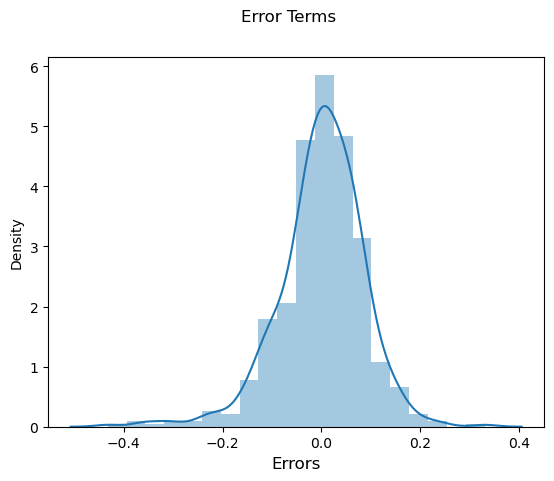

In [45]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot(res, bins = 20)
fig.suptitle('Error Terms', fontsize = 12)                  # Plot heading 
plt.xlabel('Errors', fontsize = 12)            

Based on this plot we can see that the error terms are normally distributed 

#### 6.2. Error terms are independent of each other 
Error terms should be independent. We can see this using a scatter plot

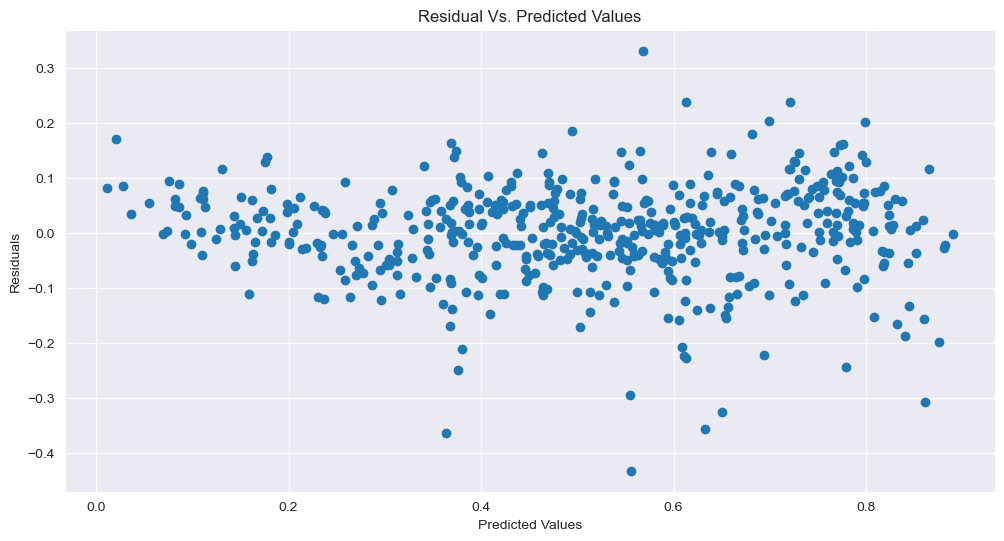

In [46]:
plt.figure(figsize = (12,6))
sns.set_style("darkgrid")
plt.scatter(y_train_pred,res)
plt.title('Residual Vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

We can see there is no specific Pattern observed in the Error Terms with respect to Prediction, hence we can say that the Error terms are independent of each other.

#### 6.3. Error terms should have constant variance
This property is also called Homoscedasticity

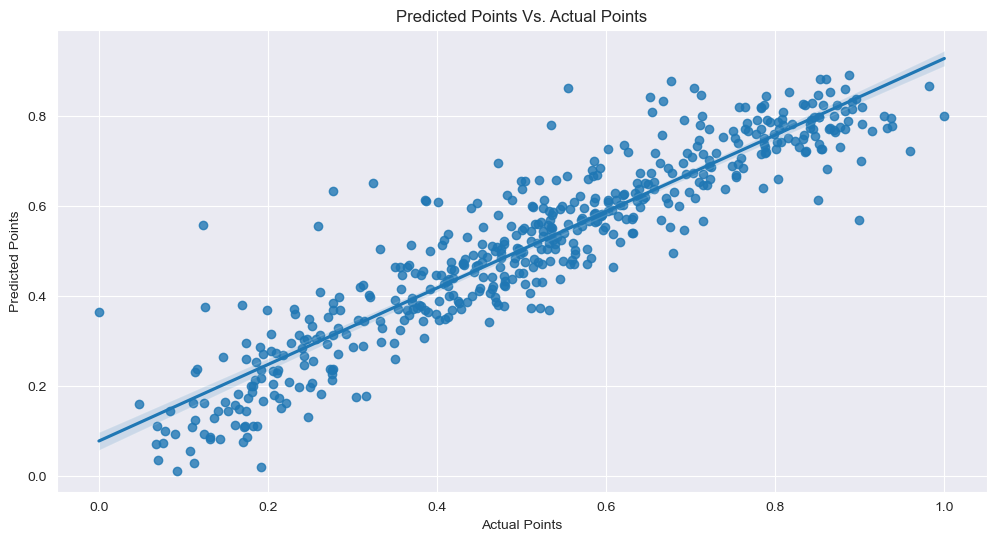

In [47]:
plt.figure(figsize = (12,6))
sns.set_style("darkgrid")
sns.regplot(x=y_train, y=y_train_pred)
plt.title('Predicted Points Vs. Actual Points')
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.show()

We can see Error Terms have approximatly a Constant Variance, Hence it follows the Assumption of Homoscedasticity

# 7. Model Evaluation on test dataset

In [48]:
print(df_test.shape)
#Scaling of test dataset

# Apply scaler to all the columns except 'yes-no' and 'dummy' variables
continous_vars = ['temp','atemp','humidity','windspeed','casual','registered','cnt']
df_test[continous_vars] = scaler.fit_transform(df_test[continous_vars])

# head after scaling
df_test.head()

(220, 32)


,year,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,cnt,...,sat,sun,thu,tue,wed,LightSnow,Mist,spring,summer,winter
184,0,1,0,0.837241,0.778767,0.534223,0.149393,0.898559,0.397068,0.704300,...,0,0,0,0,0,0,1,0,0,0
535,1,0,1,0.911423,0.855132,0.470417,0.231142,0.253749,0.765284,0.725421,...,0,0,0,0,1,0,0,0,1,0
299,0,0,1,0.496221,0.492359,0.777843,0.443398,0.067921,0.309888,0.278853,...,0,0,1,0,0,0,1,0,0,1
221,0,0,1,0.890387,0.805661,0.236659,0.449707,0.257277,0.540237,0.545512,...,0,0,0,0,1,0,0,0,0,0
152,0,0,1,0.821739,0.749249,0.070765,0.682387,0.213761,0.592639,0.569148,...,0,0,1,0,0,0,0,0,1,0


In [49]:
# derive X_test and y_test
y_test = df_test.pop('cnt')
X_test = df_test
X_test_sm = sm.add_constant(X_test)
X_test_sm.head()

,const,year,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,...,sat,sun,thu,tue,wed,LightSnow,Mist,spring,summer,winter
184,1.0,0,1,0,0.837241,0.778767,0.534223,0.149393,0.898559,0.397068,...,0,0,0,0,0,0,1,0,0,0
535,1.0,1,0,1,0.911423,0.855132,0.470417,0.231142,0.253749,0.765284,...,0,0,0,0,1,0,0,0,1,0
299,1.0,0,0,1,0.496221,0.492359,0.777843,0.443398,0.067921,0.309888,...,0,0,1,0,0,0,1,0,0,1
221,1.0,0,0,1,0.890387,0.805661,0.236659,0.449707,0.257277,0.540237,...,0,0,0,0,1,0,0,0,0,0
152,1.0,0,0,1,0.821739,0.749249,0.070765,0.682387,0.213761,0.592639,...,0,0,1,0,0,0,0,0,1,0


In [50]:
#drop columns dropped during model training
X_test_sm=X_test_sm.drop(['aug', 'june', 'mar', 'oct', 'mon', 'sun', 'thu', 'tue', 'wed','registered','casual','atemp','may','feb','holiday'],axis=1)

In [51]:
X_test_sm.shape

(220, 17)

#### 7.1. Predict values of test using the model

In [52]:
# Predict the Price for Test Data using the Trainned Model
y_test_pred= final_model.predict(X_test_sm)

#### 7.2. R2_score

In [53]:
#r2_score of train dataset
r2_score(y_train, y_train_pred)

0.8491899138694096

In [54]:
#r2_score of test dataset
r2_score(y_test, y_test_pred)

0.8225057381318333

#### Conclusions on model accuracy:
1. The final model accuracy is about **85%** which is very good. 
2. The Model accuracy difference between the Train and Test Data is close to **3%** which is acceptable.

# 8. Insights from the model

#### 8.1 Coefficients:

In [55]:
#model coefficients are 
Cofficients = round(final_model.params,2)
beta = Cofficients.sort_values(ascending = False)
beta

temp          0.47
const         0.27
year          0.23
winter        0.10
sep           0.07
sat           0.06
workingday    0.05
summer        0.04
dec          -0.04
nov          -0.04
jan          -0.05
july         -0.05
Mist         -0.06
spring       -0.06
humidity     -0.15
windspeed    -0.19
LightSnow    -0.26
dtype: float64

#### 8.2. Equation of the straight line corresponding to the final MLR model

In [56]:
#code to generate the equation: 
for i in range(0, len(beta)):
    print(beta[i],'*',beta.index[i],end ='')
    print(' + ',end ='')

0.47 * temp + 0.27 * const + 0.23 * year + 0.1 * winter + 0.07 * sep + 0.06 * sat + 0.05 * workingday + 0.04 * summer + -0.04 * dec + -0.04 * nov + -0.05 * jan + -0.05 * july + -0.06 * Mist + -0.06 * spring + -0.15 * humidity + -0.19 * windspeed + -0.26 * LightSnow + 

#### Equation of the line is :
**cnt= 0.27 + 0.47 * temp + 0.23 * year + 0.1 * winter + 0.07 * sep + 0.06 * sat + 0.05 * workingday + 0.04 * summer -0.04 * dec -0.04 * nov -0.05 * jan -0.05 * july -0.06 * Mist -0.06 * spring -0.15 * humidity -0.19 * windspeed -0.26 * LightSnow**

#### 8.2.1. Observations based on the equation:  

##### Observations: 
1. Predictors with positive Correlation to demand for bike sharing (The predictors with positive coefficients): 
    An increase in these factors will influence the  demand for bike sharing positively.
-  temperature : 0.47
-  year(2019)  : 0.23
-  Winter : 0.1
-  september month : 0.07
-  saturday : 0.06
-  Working day : 0.05 
-  summer : 0.04

2. Predictors with negative correlation to  demand for bike sharing (The predictors with negative coefficients): 
   An increase in these factors will influence the  demand for bike sharing negatively. 
-  December month: -0.04
-  November month: -0.04
-  January month : -0.05
-  July Month : -0.05
-  Mist (weather conditions: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist) : -0.06
-  Spring Season: -0.06
-  humidity: -0.15
-  windspeed : -0.19
-  LightSnow : (weather:Light Snow,Light Rain+Thunderstorm+Scattered clouds,Light Rain+Scattered clouds): -0.26
   

#### 8.3. Insights from the final MLR model:

#### Insights: 
1. Based on the equation of the final model , we see that the demand for bike sharing is most influenced by temperature, which has the highest positive coefficient. So Boom Bikes can come up with strategies to give comfort to the users when the temparature is adverse, like adding a shelter kind of option on the bike , increasing/decreasing the availability of the bikes based on temperature etc., 
2. Without any changes, assuming constant weather conditions as in the test data, we can see that year on year the sharing sees an upward trend. This gived confidence to boom bikes to invest more in this market and to plan how much,
3. We also see that, assuming all conditions stay as is, the bike sharing marker still sees an upward trend of business, with the booking incresing , as we see a postive coefficient of 0.27
4. We can also notice that the sales are also influenced by the fact that, the day of the week is a saturday. It can be accounted to the fact that, since it the start of the weekend, users tend to rent more bikes during saturdays. Boom Bikes should ensure to adjust stocks and promotions to attract more users on saturdays, to influence the business futeht postively . 
5. We can also clearly see that climatic conditions like seasons(summer and winter ) tend to augument bike shring where as weather conditions like Mist, snow and windspeed and humidity tend to influence the demand for sharing negatively. Boom Bikes should plan to also analyse this data by also collecting information based on the regions/ specific states and take steps to influence the demand for sharing positively by adjusting vehicle inventory at different locations based on climatic factors and their influence in that region.